<a href="https://colab.research.google.com/github/team0243/practic/blob/main/Train_Detectron2_Segmentation_on_Custom_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Preparing the dataset**\
Prepare the dataset using Labelme annotation tool (for Instance segmentation) and LabelImg for object detection.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing Detectron2 on Colab**


In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15508, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 15508 (delta 66), reused 181 (delta 42), pack-reused 15275
Receiving objects: 100% (15508/15508), 6.39 MiB | 15.95 MiB/s, done.
Resolving deltas: 100% (11180/11180), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [4]:
# check pytorch installation:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("2.1")   # please manually install torch 1.8 if Colab changes its default version


2.1.0+cu121 True


In [5]:
import torchvision
import cv2

**Register the data to Detectron2 config**


In [6]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [12]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}

        filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["height"] = 512
        record["width"] = 512

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [7]:
classes = ['Macronucleoli', 'Mitosis-like']
data_path = "/content/drive/MyDrive/Meningioma_Detection.coco/"
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/Meningioma_Detection.coco/train/_annotations.coco.json", "/content/drive/MyDrive/Meningioma_Detection.coco/train")
register_coco_instances("my_dataset_test", {},  "/content/drive/MyDrive/Meningioma_Detection.coco/test/_annotations.coco.json", "/content/drive/MyDrive/Meningioma_Detection.coco/test")
register_coco_instances("my_dataset_val", {},  "/content/drive/MyDrive/Meningioma_Detection.coco/valid/_annotations.coco.json", "/content/drive/MyDrive/Meningioma_Detection.coco/valid")

print("Done...")


Done...


Training the Detectron2 Instance Segmentation Model


In [8]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer


In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[03/13 06:26:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:01, 227MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


In [11]:
trainer.train()

[03/13 06:26:27 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/13 06:26:45 d2.utils.events]:  eta: 0:10:22  iter: 19  total_loss: 1.841  loss_cls: 1.229  loss_box_reg: 0.05321  loss_rpn_cls: 0.5014  loss_rpn_loc: 0.02833    time: 0.6537  last_time: 0.6958  data_time: 0.1059  last_data_time: 0.1734   lr: 4.9953e-06  max_mem: 3911M
[03/13 06:27:01 d2.utils.events]:  eta: 0:09:04  iter: 39  total_loss: 1.359  loss_cls: 0.9583  loss_box_reg: 0.06889  loss_rpn_cls: 0.2918  loss_rpn_loc: 0.01796    time: 0.6098  last_time: 0.5319  data_time: 0.0392  last_data_time: 0.0232   lr: 9.9902e-06  max_mem: 3916M
[03/13 06:27:12 d2.utils.events]:  eta: 0:08:48  iter: 59  total_loss: 0.9827  loss_cls: 0.5999  loss_box_reg: 0.05396  loss_rpn_cls: 0.273  loss_rpn_loc: 0.01785    time: 0.5889  last_time: 0.5162  data_time: 0.0419  last_data_time: 0.0059   lr: 1.4985e-05  max_mem: 3918M
[03/13 06:27:23 d2.utils.events]:  eta: 0:08:34  iter: 79  total_loss: 0.718  loss_cls: 0.3838  loss_box_reg: 0.11  loss_rpn_cls: 0.1173  loss_rpn_loc: 0.01947    time: 0.5725  la

In [40]:
data_path_test = "/content/drive/MyDrive/Meningioma_Detection.coco/test/_annotations.coco.json"
train_metadata = MetadataCatalog.get("my_dataset_train") #****
test_metadata = MetadataCatalog.get("my_dataset_test") #**** display images label and predict

**Inference using the Trained Model**


In [35]:
import cv2
from google.colab.patches import cv2_imshow

In [21]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)



[03/13 06:40:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


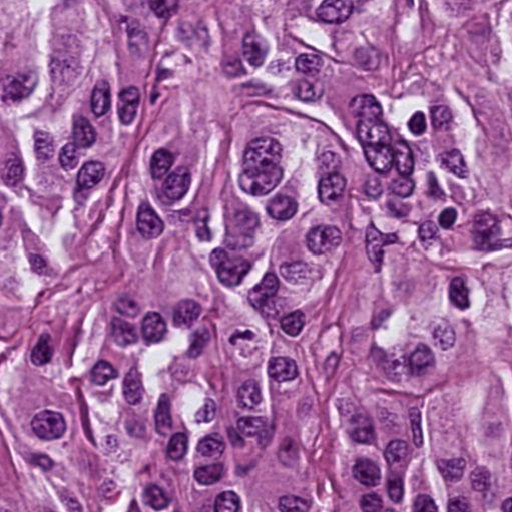

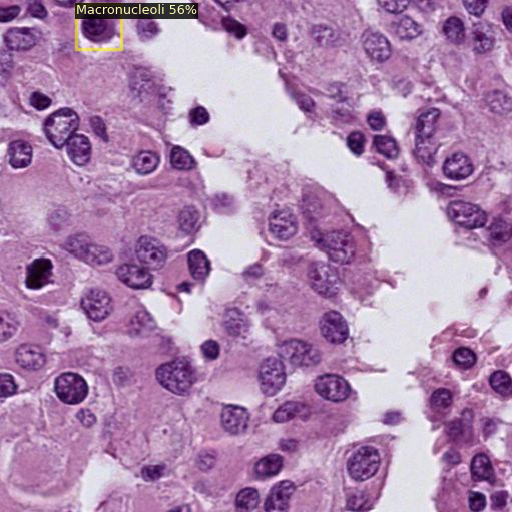

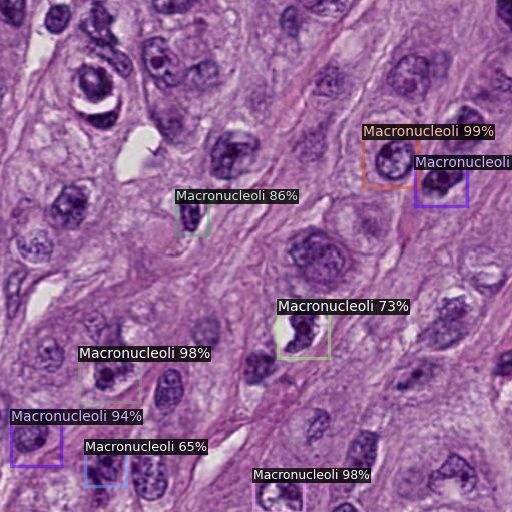

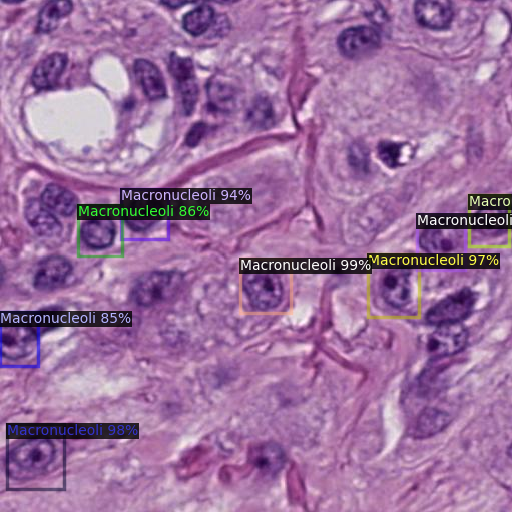

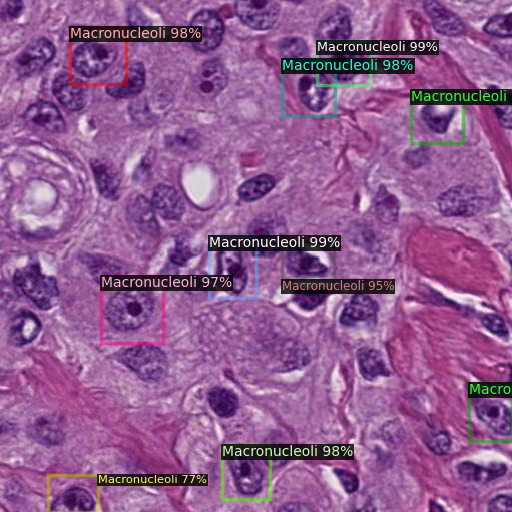

In [42]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob("/content/drive/MyDrive/Meningioma_Detection.coco/test/*jpg"): #test form  jpg file
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=train_metadata, # usd train_matadata for predict meningioma
                scale=1
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  print("\n")